# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
import pickle
from random import shuffle
import numpy as np
from itertools import groupby

training_file = "train.p"
testing_file = "test.p"


def shuffle_train_set():
    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    
    zipped = list(zip(train['features'], train['labels']))
    shuffle(zipped)
    unzipped = list(zip(*zipped))
    
    dictionary = {'features': np.array(unzipped[0]),
                  'labels': np.array(unzipped[1])}
    
    pickle.dump(dictionary, open(training_file, "wb"))
    
    return

# don' want it to shuffle everytime
# shuffle_train_set()

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

def to_onehot(label, labels_num):
    result = np.zeros(labels_num)
    result[label] = 1
    return result
    
def to_onehot_list(labels):
    labels_num = len(list(groupby(sorted(labels))))
    return list(map(lambda label: to_onehot(label, labels_num), labels))

y_train_onehot = to_onehot_list(y_train)
y_test_onehot = to_onehot_list(y_test)

In [2]:
n_train = X_train.shape[0]

n_test = X_test.shape[0]

image_shape = np.array(X_test.shape[1:])

n_classes = len(list(groupby(sorted(y_train))))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = [32 32  3]
Number of classes = 43


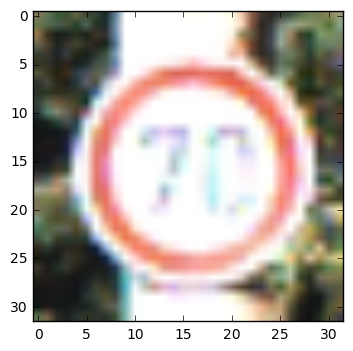

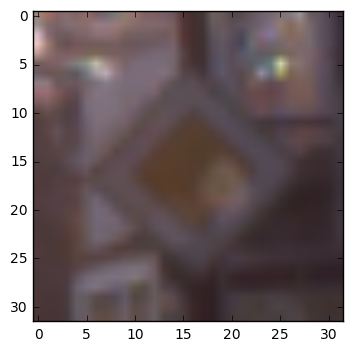

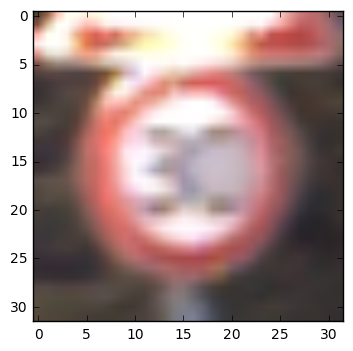

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(X_train[0])
plt.figure()
plt.imshow(X_train[1])
plt.figure()
plt.imshow(X_train[500])

In [4]:
import csv

def get_signs_names():
    result = {}
    with open('signnames.csv') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            classId = int(row['ClassId'])
            name = row['SignName']
            result[classId] = name
    return result
                    
sign_names = get_signs_names()

In [5]:
def count_and_print_signs(classes):
    for sign, entries in groupby(sorted(classes)):
        print(sign_names[sign], ":", len(list(entries)))
    
    return

print("Train set:")
count_and_print_signs(y_train)
print("\nTest set:")
count_and_print_signs(y_test)

Train set:
Speed limit (20km/h) : 210
Speed limit (30km/h) : 2220
Speed limit (50km/h) : 2250
Speed limit (60km/h) : 1410
Speed limit (70km/h) : 1980
Speed limit (80km/h) : 1860
End of speed limit (80km/h) : 420
Speed limit (100km/h) : 1440
Speed limit (120km/h) : 1410
No passing : 1470
No passing for vechiles over 3.5 metric tons : 2010
Right-of-way at the next intersection : 1320
Priority road : 2100
Yield : 2160
Stop : 780
No vechiles : 630
Vechiles over 3.5 metric tons prohibited : 420
No entry : 1110
General caution : 1200
Dangerous curve to the left : 210
Dangerous curve to the right : 360
Double curve : 330
Bumpy road : 390
Slippery road : 510
Road narrows on the right : 270
Road work : 1500
Traffic signals : 600
Pedestrians : 240
Children crossing : 540
Bicycles crossing : 270
Beware of ice/snow : 450
Wild animals crossing : 780
End of all speed and passing limits : 240
Turn right ahead : 689
Turn left ahead : 420
Ahead only : 1200
Go straight or right : 390
Go straight or left

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [6]:
import tensorflow as tf

x = tf.placeholder("float", [None, image_shape[0], image_shape[1], image_shape[2]])
y = tf.placeholder("float", [None, n_classes])

def create_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

def create_biases(shape):
    return tf.Variable(tf.constant(0.1, shape = shape))

def conv2d(input_layer, out_channels, stride=1, padding='SAME'):
    input_shape = input_layer.get_shape().as_list()
    
    weights_shape = [input_shape[1], input_shape[2], input_shape[3], out_channels]
       
    weights = create_weights(weights_shape)
    biases = create_biases([out_channels])
    
    output_layer = tf.nn.conv2d(input_layer, weights, [1, stride, stride, 1], padding)
    output_layer = tf.nn.bias_add(output_layer, biases)
    
    return output_layer

def max_pool(input_layer, size=2, padding='SAME'):
    dimensions = [1, size, size, 1]
    return tf.nn.max_pool(input_layer, dimensions, dimensions, padding)

def densely_connected(input_layer, output_nodes_number):
    input_shape = input_layer.get_shape().as_list()
    flat_size = np.prod(input_shape[1:]) 
    
    flat_input = tf.reshape(input_layer, [-1, flat_size])
    
    weights = create_weights([flat_size, output_nodes_number])
    biases = create_biases([output_nodes_number])
    
    result = tf.matmul(flat_input, weights)
    result = tf.nn.bias_add(result, biases)
    
    return result

def create_net():     
    layer1 = conv2d(x, 30)     
    layer1 = tf.nn.relu(layer1)
       
    layer2 = max_pool(layer1)
    
    layer3 = conv2d(layer2, 10)
    layer3 = tf.nn.relu(layer3)
    
    layer4 = max_pool(layer3)
                      
    layer5 = densely_connected(layer4, n_classes)
    layer5 = tf.nn.relu(layer5)
    
    return layer5
    

net = create_net()

loss_function = tf.reduce_mean(-tf.reduce_sum(y * tf.log(net), reduction_indices=[1]))    

In [ ]:
EPOCHS = 10
BATCH_SIZE = 1000
LEARNING_RATE = 0.01
BATCH_LIMIT = 1
TEST_SIZE_LIMIT = 100

optimizer = tf.train.GradientDescentOptimizer(learning_rate = LEARNING_RATE).minimize(loss_function)


def chunks(list, chunk_size):
    return [list[i:i+chunk_size] for i in range(0, len(list), chunk_size)]

def create_batches(features, labels, batch_size):
    zipped = list(zip(features, labels))
    shuffle(zipped)
    unzipped = list(zip(*zipped))
    
    new_features = chunks(unzipped[0], batch_size)
    new_labels = chunks(unzipped[1], batch_size)
    
    return list(zip(new_features, new_labels))

def evaluate_net_and_print(epoch, session):
    correct_prediction = tf.equal(tf.argmax(net, 1), tf.argmax(y, 1))
    accuracy_function = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    train_features = X_test[:TEST_SIZE_LIMIT]
    train_labels = y_test_onehot[:TEST_SIZE_LIMIT]
    test_accuracy = session.run(accuracy_function, feed_dict={x: train_features, y: train_labels})
    print("Test accuracy: {0:.3f}. Epoch {1}".format(test_accuracy, epoch + 1))

with tf.Session() as session:
    session.run(tf.initialize_all_variables())
        
    for epoch in range(EPOCHS):
        batches = create_batches(X_train, y_train_onehot, BATCH_SIZE)
        for features, labels in batches[:BATCH_LIMIT]:
            session.run(optimizer, feed_dict={x: features, y: labels})
        evaluate_net_and_print(epoch, session)



None
Test accuracy: 0.040. Epoch 1
None
Test accuracy: 0.040. Epoch 2


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

In [ ]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.